# Code Setup
This includes connecting to the Google Drive and importing Python libraries and various other tools

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
import numpy as np7
from numpy import sqrt
from numpy import argmax
import pandas as pd
from collections import Counter

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras import initializers
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras import backend as K
import keras
from keras.optimizers import SGD, RMSprop
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Data Preparation
Preparing the data to be used in the model. This includes separating inputs and designated outputs, and splitting the dataset into training, validation, and testing sets.

In [126]:
# Read from the dataset and save the pandas file to "dataset"
dataset = pd.read_csv('/content/drive/MyDrive/PulsarStarsClassifier/pulsar_data_train.csv')

# Remove all rows with null values
print(type(dataset))
dataset.dropna(inplace=True)

# X is the data we are inputting into the model, Y is the classified result of the corresponding X
X = dataset.iloc[:, [0,1,2,3,4,5,6,7,]].values
y = dataset.iloc[:, 8].values

<class 'pandas.core.frame.DataFrame'>


In [127]:
# Pre-set ratios for splitting the dataset into training, validation, and testing
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Randomly dividing the dataset and assigning them to the corresponding sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

# Showing the length of each set, as well as how many "detected stars" there are
print("Training: " + str(len(x_train)) + " " + str(Counter(y_train)))
print("Validation: " + str(len(x_val)) + " " + str(Counter(y_val)))
print("Testing: " + str(len(x_test)) + " " + str(Counter(y_test)))

Training: 6491 Counter({0.0: 5904, 1.0: 587})
Validation: 1391 Counter({0.0: 1263, 1.0: 128})
Testing: 1391 Counter({0.0: 1256, 1.0: 135})


# Building the neural network
This includes defining the layers of the model, the learning rate, loss, and optimizers. The model is also trained under this section

In [128]:
# Creating our model
model1 = Sequential()
model1.add(Dense(8, input_shape=(8,)))
model1.add(Dense(1500, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Set the learning rate
opt = keras.optimizers.Adam(learning_rate=0.001)

# Prints a detailed summary of the model
model1.summary()


# Set the optimizer and loss function
model1.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 8)                 72        
                                                                 
 dense_33 (Dense)            (None, 1500)              13500     
                                                                 
 dense_34 (Dense)            (None, 1)                 1501      
                                                                 
Total params: 15073 (58.88 KB)
Trainable params: 15073 (58.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
# Training the model, with each epoch representing each time the model is trained over the entire training set
history = model1.fit(x_train, y_train, batch_size=8, epochs=50, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
812/812 [==============================] - 5s 4ms/step - loss: 0.2865 - accuracy: 0.9535 - val_loss: 0.1423 - val_accuracy: 0.9648
Epoch 2/50
812/812 [==============================] - 3s 4ms/step - loss: 0.1552 - accuracy: 0.9663 - val_loss: 0.1779 - val_accuracy: 0.9540
Epoch 3/50
812/812 [==============================] - 3s 3ms/step - loss: 0.1177 - accuracy: 0.9684 - val_loss: 0.1020 - val_accuracy: 0.9734
Epoch 4/50
812/812 [==============================] - 3s 3ms/step - loss: 0.1066 - accuracy: 0.9709 - val_loss: 0.0943 - val_accuracy: 0.9734
Epoch 5/50
812/812 [==============================] - 3s 4ms/step - loss: 0.0994 - accuracy: 0.9723 - val_loss: 0.0954 - val_accuracy: 0.9720
Epoch 6/50
812/812 [==============================] - 4s 5ms/step - loss: 0.0963 - accuracy: 0.9729 - val_loss: 0.0951 - val_accuracy: 0.9734
Epoch 7/50
812/812 [==============================] - 3s 4ms/step - loss: 0.0933 - accuracy: 0.9720 - val_loss: 0.1019 - val_accuracy: 0.9734
Epoch 

# Predicting Results
This section aims to gauge how well our model works

In [130]:
# Uses our trained model to predict whether an input is a pulsar star or not. The predicted result is saved to "y_pred"
y_pred = model1.predict(x_test)

44/44 [==============================] - 0s 2ms/step


In [131]:
print(y_pred)

[[0.00038312]
 [0.00084198]
 [0.00877007]
 ...
 [0.002005  ]
 [0.03805342]
 [0.00060883]]


# Understanding the Results
This includes finding the threshold, using various methods to determine how well the model works, and graphing a confusing matrix.

Best Threshold=0.132973, G-Mean=0.957


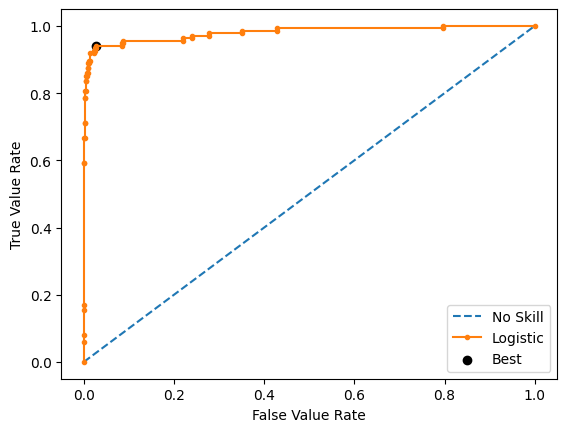

In [132]:
# Finding the threshold based on the predicted results and the true results
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# This is the best threshold
thres = thresholds[ix]

# Plotting a graph to show the threshold
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# Axis labels
pyplot.xlabel('False Value Rate')
pyplot.ylabel('True Value Rate')
pyplot.legend()

# Show the plot
pyplot.show()

In [133]:
# Loop through predicted results and convert them all to 0 or 1
boolResultArray = []
score = 0
for i in range(len(y_pred)):
    if y_pred[i] < thres:
      boolResultArray.append(0.0)
    else:
      boolResultArray.append(1.0)
print(Counter(boolResultArray))

Counter({0.0: 1231, 1.0: 160})


In [134]:
# Print a summary of the results, measured in precision, recall, f1-score, support, and accuracy
print(classification_report(y_test, boolResultArray))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1256
         1.0       0.79      0.94      0.86       135

    accuracy                           0.97      1391
   macro avg       0.89      0.96      0.92      1391
weighted avg       0.97      0.97      0.97      1391



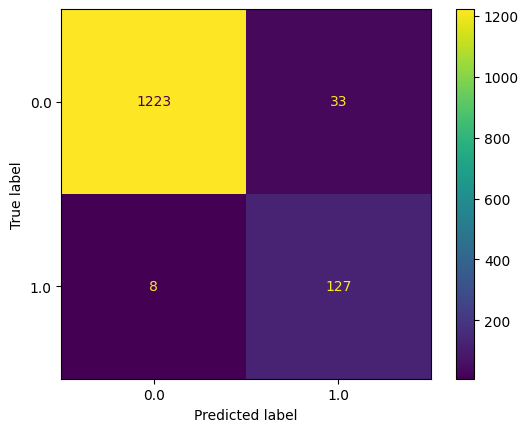

In [135]:
# Plotting a confusion matrix

# Defining the axes
classes = ([0.0, 1.0])
cm = confusion_matrix(y_test, boolResultArray)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot()

plt.show()


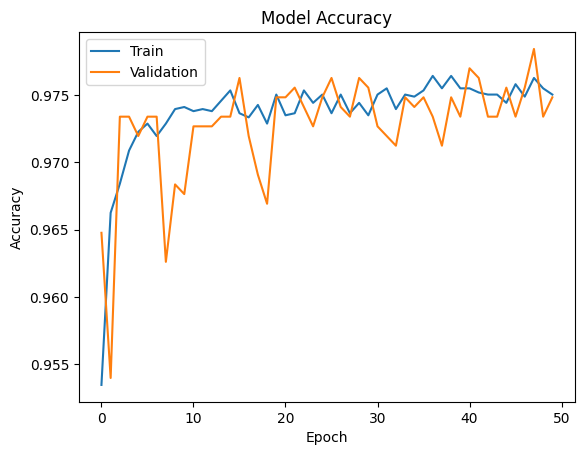

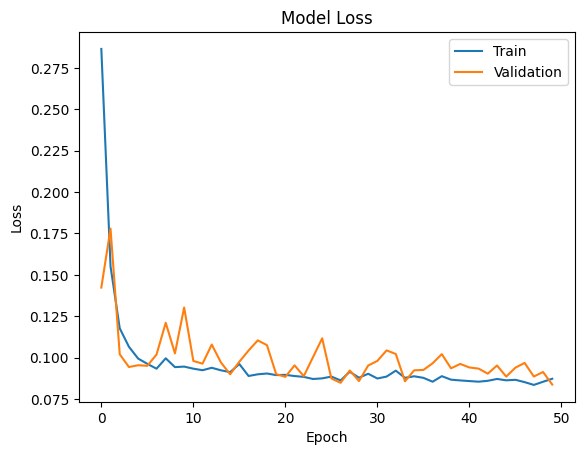

In [136]:
# Plot graphs to model training accuracy and validation accuracy as it was trained over epochs
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot graphs to model training loss and validation loss as it was trained over epochs
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
